## SQL Loan-Income-State Database for Loan Risk Analysis

## 100 Points (will be converted to 15 points)

In this assignment, you will work on the Home Mortgage Disclosure Act (HMDA) dataset from US government ([link](https://www.consumerfinance.gov/data-research/hmda/historic-data/)). Specifically, you will work on the nationalwide records of 2015 as a zipped CSV file (`hmda_2015_nationwide_first-lien-owner-occupied-1-4-family-records_labels.zip`).

**<font color="red">The goal of this assignment is to gather statistics useful to estimate the percentage of high risk applicants per state. The obtained results are presented as an SQL table accompanied by a scatter plot of average income versus average loan amount for every US state.</font>**

This goal is achieved by completing five major tasks:

- [Data Extraction (collect applicants Loan-Income per state) and Cleaning (remove missing values)](#task-1-15-pts-data-extraction-collect-applicants-loan-income-per-state-and-cleaning-remove-missing-values)
- [Statistics per State of the Loan-Income-Applicants Data (min, max, average)](#task-2-30-pts-statistics-per-state-of-the-loan-income-applicants-data-min-max-average)
- [Creation of a Basic SQL Table from the Loan-Income-State Data](#task-3-15-pts-creation-of-a-basic-sql-table-from-the-loan-income-state-data)
- [Detection of High-Loan and High-Risk Applicants and Extension of the Basic SQL Table with this Information](#task-4-20-pts-detection-of-high-loan-and-high-risk-applicants-and-extension-of-the-basic-sql-table-with-this-information)
- [Creation of a Scatter Plot of High-Risk States (average income versus average loan amount)](#task-5-5-pts-creation-of-a-scatter-plot-of-high-risk-states-average-income-versus-average-loan-amount)

### Note: The first step to complete is to import the necessary libraries indicated below

Please make sure you run the next cell to import the necessary libraries before you start working on the assigned tasks.

In [1]:
# For reading csv in zip files
import zipfile
from io import TextIOWrapper
import csv

# For plots
from matplotlib import pyplot as plt

# For connecting to MySQL
from mysql.connector import connect, Error
import time

# user-defined module to get all the states' abbreviations
from util import state_abbrs

#another import
import numpy as np
#import sys, mysql.connector
#print(mysql.connector.__version__)
#print(sys.executable)

### Task 1 (15 pts): Data Extraction (collect applicants Loan-Income per state) and Cleaning (remove missing values)

#### Subtask 1.1 (5 pts): Extract the data from the zipped CSV file

Write a function `read_zip_csv` following the code template provided below. This function should take three inputs and produce one output as indicated next. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.


- **Input 1**: a string `zip_file_name` representing the path to a zip file.
- **Input 2**: a string `csv_file_name` representing the name of a CSV file within the zip file.
- **Input 3**: a list of string `column_names` specifying the names of the columns of interest.
- **Output**: a list of lists of strings `data`, where each inner list represents a row containing only the specified columns according to **Input 3** from the CSV file.

Note: In order to complete the missing code, it is imperative that you understand the intended purpose of the code template.

In [2]:
def read_zip_csv(zip_file_name, csv_file_name, column_names):
    """
    Read a csv file from a zip file, and return data in the specified columns
    IN: zip_file_name, str, the name of the zip file
        csv_file_name, str, the name of the csv file in the zip file
        column_names, list[str], the names of the columns to extract
    OUT: data, list[list[str]], the data from the csv file in the specified columns
    """

    data = []
    # use zipfile to open the zip file directly
    with zipfile.ZipFile(zip_file_name) as z:
        with z.open(csv_file_name) as f:
            # use csv to read the zipped csv file
            reader = csv.DictReader(TextIOWrapper(f, 'utf-8'))
            # iterate through the rows of the csv file
            for idx, row in enumerate(reader, start=1):
                # extract the data in the specified columns
                data.append([str(row.get(col," ")) for col in column_names])
                
                if idx % 1_000_000 == 0:
                    print(f"Read {idx} rows")
    return data

In this assignment, we are interested in the following three columns of the HMDA dataset: `state_abbr`, `loan_amount_000s` and `applicant_income_000s`. Please run the cell below to extract the information in these three columns before moving on to the next subtask.

In [3]:
if __name__ == "__main__":
    # The code in this cell calls the function defined above.
    # It loads the three columns into a Python list named `data`.
    # Before proceeding, it is a good idea to run this code to see a snapshot of the data.
    data = read_zip_csv(
        "hmda_2015_nationwide_first-lien-owner-occupied-1-4-family-records_labels.zip",
        "hmda_2015_nationwide_first-lien-owner-occupied-1-4-family-records_labels.csv",
        ['state_abbr', 'loan_amount_000s', 'applicant_income_000s']
    )
    # print the first 5 rows of the data
    print(data[:5])

Read 1000000 rows
Read 2000000 rows
Read 3000000 rows
Read 4000000 rows
Read 5000000 rows
Read 6000000 rows
[['CA', '265', '91'], ['CA', '417', '150'], ['OR', '148', '53'], ['FL', '264', '60'], ['ME', '285', '115']]


#### Subtask 1.2 (10 pts): Clean the extracted data

Write a function `clean_data` that takes two inputs and produces two outputs as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a list of lists of strings `data` as extracted from the CSV file. Each sublist represents a row with the relevant columns.
- **Input 2**: a list of functions `cleaners`. Each function converts values in a specific column to a desired type, with the order of functions in the list matching the column order in `data`. Each function should have the following signature:
    - **input**: a string `column_value` to be cleaned.
    - **output**: A cleaned value (of type string, int, or float, depending on the column).
- **Output 1**: a list of tuples `cleaned_data`, where each tuple represents a row of cleaned data in the desired types.
- **Output 2**: a pair of integers `(n_rows_cleaned, n_rows_discarded)` representing the number of rows cleaned and the number discarded, respectively.

Note: If a value in a row fails to be cleaned, the entire row should be discarded.

In [4]:
def clean_data(data, cleaners):
    """
    Clean the data using the specified cleaners
    IN: data, list[list[str]], the data to clean
        cleaners, list[function(str) -> any], the functions to clean each column
    OUT: cleaned_data, list[tuple], the cleaned data
         (n_rows_cleaned, n_rows_discarded), tuple(int, int) the number of rows cleaned and discarded
    """

    cleaned_data = []
    n_rows_cleaned = 0
    n_rows_discarded = 0
    for row in data:
        # use try-except to filter out the rows that cannot be cleaned
        try:
            cleaned_row = tuple(func(val) for func, val in zip(cleaners, row))


        except ValueError as e:
            # some values in the row are invalid, so discard the row
            n_rows_discarded += 1

        else:
            # all values in the row are valid, so append the cleaned row
            cleaned_data.append(cleaned_row)
            n_rows_cleaned += 1
            

    return cleaned_data, (n_rows_cleaned, n_rows_discarded)

In this assignment, we need to clean the data in the following ways:

- `state_abbr`: convert to uppercase letters, and if it is not a valid 2-letter state abbreviation, discard the row.
- `loan_amount_000s`: convert to integers, and if it is empty, discard the row.
- `applicant_income_000s`: convert to integers, and if it is empty, discard the row.

In [5]:
def clean_state_abbr(column_value):
    """
    Clean a state abbreviation
    IN: column_value, str, the state abbreviation to clean
    OUT: str, the cleaned state abbreviation in uppercase
    EXCEPTION: ValueError, if the state abbreviation is not valid
    """
    # state_abbrs is a set of all the state abbreviations
    # you can use it to check if a state abbreviation is valid
    """__Your_Code_Here__"""
    s = (column_value or "").strip().upper()
    if len(s) != 2 or s not in state_abbrs:
        raise ValueError("Invalid State Abbreviation")
    return s

def clean_loan_amount(column_value):
    """
    Clean a loan amount
    IN: column_value, str, the loan amount to clean
    OUT: int, the cleaned loan amount
    EXCEPTION: ValueError, if the loan amount is not an integer
    """
    # convert to integer
    """__Your_Code_Here__"""
    s = (column_value or "").strip()
    if s == "":
        raise ValueError("Empty Loan Amount")
    s.replace(",","")
    return int(s)

def clean_applicant_income(column_value):
    """
    Clean an applicant income
    IN: column_value, str, the applicant income to clean
    OUT: int, the cleaned applicant income
    EXCEPTION: ValueError, if the applicant income is not an integer
    """
    # convert to integer
    """__Your_Code_Here__"""
    s = (column_value or "").strip()
    if s == "":
        raise ValueError("Empty Applicant Income")
    s.replace(",","")
    return int(s)

Please run the cell below to clean the three columns before moving on to the next task.

In [ ]:
if __name__ == "__main__":
    # The code in this cell calls the functions defined above.
    # It cleans the data using the specified cleaners.
    # Before proceeding, it is a good idea to run this code to see a snapshot of the cleaned data.
    cleaned_data, (n_rows_cleaned, n_rows_discarded) = clean_data(
        data,
        [
            clean_state_abbr,
            clean_loan_amount,
            clean_applicant_income,
        ],
    )
    # print the first 5 rows of the cleaned data
    print(cleaned_data[:5])
    # print the number of rows cleaned and discarded
    print(n_rows_cleaned, n_rows_discarded)

### Task 2 (30 pts): Statistics per State of the Loan-Income-Applicants Data (min, max, average)

#### Subtask 2.1 (12 pts): Check the statistics of the cleaned data and store the results in dictionaries

Write a function `check_data` that takes three inputs and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a list of tuples `cleaned_data` representing cleaned rows from the CSV file.
- **Input 2**: a list of functions `checkers`. Each function checks a specific column, with the order of functions in the list matching the column order in`cleaned_data`. Each function should have the following signature:
    - **input a**: a cleaned data value (string, int, or float, depending on the column).
    - **input b**: a dictionary representing the statistical summary of the column up to, but excluding, the current row, based on the column type.
    - **output**: A dictionary representing the updated statistical summary of the column, including the current row.
- **Input 3**: a list of dictionaries `initial_stats`, where each dictionary represents the initial statistical summary for a column. The order of dictionaries in the list should match the order of columns in `cleaned_data`.
- **Output**: a list of tuples `final_stats`, where each tuple represents the final statistical summary of a column. The order of tuples in the list should match the order of columns in `cleaned_data`.

In [ ]:
def check_data(cleaned_data, checkers, initial_stats):
    """
    Check the data using the specified checkers
    IN: cleaned_data, list[tuple], the cleaned data
        checkers, list[function(any, dict) -> dict], the functions to check each column
        initial_stats, list[dict], the initial statistics for each column
    OUT: final_stats, list[dict], the final statistics for each column
    """

    # initialize the final statistics
    final_stats = initial_stats.copy()
    # iterate through the cleaned data
    for row in cleaned_data:
        # update the statistics using the checkers
        for i, value in enumerate(row):
            checker = checkers[i]
            stats_dict = final_stats[i]
            # update the stats with this column’s checker
            final_stats[i] = checker(value, stats_dict)
    return final_stats

In this assignment we are going to check the data as follows:

- `state_abbr`: Count the occurrences of each state in the data.
- `loan_amount_000s`: Record the **dictionary** keys `min`, `max`, and `total` loan amounts (`total` can be used to calculate the average loan amount).
- `applicant_income_000s`: Record the **dictionary** keys `min`, `max`, and `total` applicant incomes (`total` can be used to calculate the average applicant income).

The initial statistical summary for each column is a **dictionary** with the following structure:
```python
state_abbr_stat = {abbr: 0 for abbr in state_abbrs}
loan_amount_000s_stat = {'min': float('inf'), 'max': float('-inf'), 'total': 0}
applicant_income_000s_stat = {'min': float('inf'), 'max': float('-inf'), 'total': 0}
```

In [ ]:
def check_state_abbr(column_value, stats):
    """
    Check a state abbreviation, updating the count of each state abbreviation
    IN: column_value, str, the state abbreviation to check
        stats, dict{state_abbr: int}, the current count of each state abbreviation
    OUT: stats, dict{state_abbr: int}, the updated count of each state abbreviation
    """
    # update counts
    """__Your_Code_Here__"""
    stats[column_value]=stats.get(column_value,0)+1

    return stats

def check_loan_amount(column_value, stats):
    """
    Check a loan amount, updating the minimum, maximum, and total loan amount
    IN: column_value, int, the loan amount to check
        stats, dict{min: int, max: int, total: int}, the current statistics for the loan amount
    OUT: dict{min: int, max: int, total: int}, the updated statistics for the loan amount
    """
    # update min, max, and total
    """__Your_Code_Here__"""
    if column_value<stats['min']:
        stats['min'] = column_value
    if column_value > stats['max']:
        stats['max'] = column_value
    stats['total'] += column_value

    return stats

def check_applicant_income(column_value, stats):
    """
    Check an applicant income, updating the minimum, maximum, and total applicant income
    IN: column_value, int, the applicant income to check
        stats, dict, the current statistics for the applicant income
    OUT: dict, the updated statistics for the applicant income
    """
    # update min, max, and total
    """__Your_Code_Here__"""
    if column_value<stats['min']:
        stats['min'] = column_value
    if column_value > stats['max']:
        stats['max'] = column_value
    stats['total'] += column_value
    return stats

Before moving on to the next subtask, please run the cell below to check the statistics of the cleaned data.

In [ ]:
if __name__ == "__main__":
    # The code in this cell calls the functions defined above.
    # It checks the cleaned data using the specified checkers.
    # Before proceeding, it is a good idea to run this code to see the final statistics
    final_stats = check_data(
        cleaned_data,
        [
            check_state_abbr,
            check_loan_amount,
            check_applicant_income,
        ],
        [
            {state: 0 for state in state_abbrs},
            {'min': float('inf'), 'max': float('-inf'), 'total': 0},
            {'min': float('inf'), 'max': float('-inf'), 'total': 0},
        ],
    )
    # print the statistics for state abbreviation
    print(final_stats[0])
    # print the statistics for loan amount
    print(final_stats[1])
    # print the statistics for applicant income
    print(final_stats[2])

{'MS': 30905, 'MT': 18616, 'RI': 17833, 'ND': 14356, 'CA': 773698, 'VA': 170224, 'TN': 116789, 'KY': 66879, 'NH': 25679, 'VT': 9838, 'MA': 137864, 'IA': 60863, 'SD': 14852, 'CO': 179199, 'OH': 191996, 'WI': 118921, 'LA': 63858, 'DE': 16251, 'CT': 55595, 'MI': 187311, 'NM': 25922, 'OK': 54561, 'IL': 232359, 'NC': 174309, 'UT': 80916, 'AK': 13461, 'AL': 68445, 'MO': 112591, 'SC': 85533, 'HI': 19554, 'NY': 173334, 'TX': 429625, 'AR': 40409, 'NV': 61941, 'MN': 127833, 'MD': 116378, 'WY': 11012, 'ID': 38450, 'IN': 125134, 'WV': 21243, 'PA': 193844, 'KS': 49711, 'ME': 20815, 'OR': 91122, 'NE': 36678, 'GA': 175591, 'WA': 169632, 'AZ': 147667, 'NJ': 134621, 'FL': 323663}
{'min': 1, 'max': 62500, 'total': 1390631712}
{'min': 1, 'max': 9999, 'total': 602699003}


#### Subtask 2.2 (4 pts): Plot the bar chart of the number of applicants by state

Write a function `plot_applicants_by_state` that takes one input and produces a plot as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input**: a dictionary `state_abbr_stat` representing the number of applicants per state.
    - **key**: a state abbreviation.
    - **value**: the number of applicants.
- **Plot**: a bar chart displaying the number of applicants per state, sorted by the applicant count in descending order. Ties should be broken by sorting state abbreviations in ascending order.
    - **x-axis**: state abbreviation.
    - **y-axis**: the number of applicants.

In [ ]:
def plot_applicants_by_state(state_abbr_stat):
    """
    Plot the number of applicants by state
    IN: state_abbr_stat, dict{str: int}, the number of applicants by state
    """

    # sort the states by the number of applicants in descending order
    """__Your_Code_Here__"""
    sorted_items = sorted(state_abbr_stat.items(), key = lambda kv:(-kv[1],kv[0]))

    # extract the states and counts
    states = [state for state, count in sorted_items]
    counts = [count for state, count in sorted_items]

    # increase the figure size to avoid overlapping labels
    plt.figure(figsize=(15, 5))

    # draw a bar plot
    # if you forgot how to specify a bar plot, you can check assignment 2
    """__Your_Code_Here__"""
    plt.figure(figsize=(15,5))
    plt.bar(states, counts)
    plt.xticks(rotation=90) # dont need this

    # set the labels and title
    plt.xlabel('State Abbreviation')
    plt.ylabel('Number of applicants')
    plt.title('Number of applicants by State')
    plt.show()

Before moving on to the next subtask, please run the cell below to plot the bar chart of the number of applicants by state.

<Figure size 1500x500 with 0 Axes>

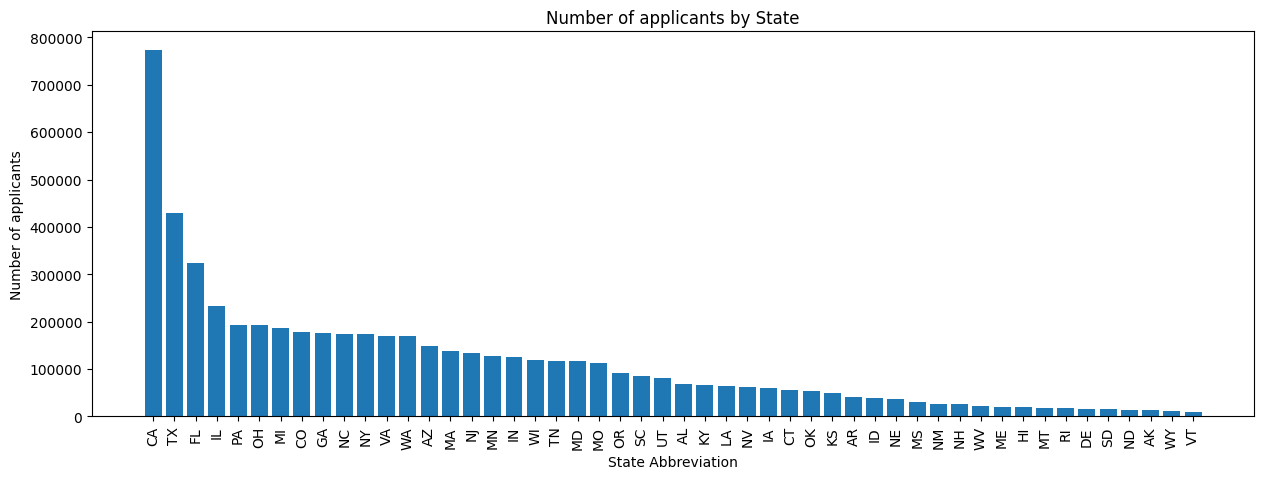

In [ ]:
if __name__ == "__main__":
    # The code in this cell calls the function defined above.
    # It plots the number of applicants by state.
    # Before proceeding, it is a good idea to run this code to see the plot.
    plot_applicants_by_state(final_stats[0])

#### Subtask 2.3 (12 pts): Plot Average Loan Amount and Average Applicant Income by State

##### Subsubtask 2.3.1 (4 pts): Calculate the total loan amount and total applicant income by state

Write a function `get_total_loan_income_by_state` that takes one input and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input**: a list of tuples `cleaned_data` extracted and cleaned from the CSV file.
- **Output**: a dictionary `total_loan_income_by_state` representing the total loan amount and total applicant income by state.
    - **key**: a state abbreviation.
    - **value**: a pair of integers `(total_loan_amount, total_applicant_income)`.

In [ ]:
from collections import defaultdict

def get_total_loan_income_by_state(cleaned_data):
    """
    Get the total loan amount and total applicant income by state
    IN: cleaned_data, list[tuple], the cleaned data
    OUT: total_loan_income_by_state, dict{str: tuple(int, int)}, the total loan amount and total applicant income by state
    """
    
    # initialize the total loan amount and total applicant income by state
    totals= defaultdict(lambda:[0,0])

    # iterate through the cleaned data to update the total loan amount and total applicant income by state
    for state_abbr, loan_amount, applicant_income in cleaned_data:
        totals[state_abbr][0] += loan_amount
        totals[state_abbr][1] += applicant_income


    total_loan_income_by_state = {s: (vals[0], vals[1]) for s, vals in totals.items()}
    return total_loan_income_by_state

Before moving on to the next subsubtask, please run the cell below to calculate the total loan amount and total applicant income by state.

In [34]:



if __name__ == "__main__":
    # The code in this cell calls the function defined above.
    # It gets the total loan amount and total applicant income by state.
    # Before proceeding, it is a good idea to run this code to see the total loan amount and total applicant income by state.
    total_loan_income_by_state = get_total_loan_income_by_state(cleaned_data)
    # print the total loan amount and total applicant income by state
    for state_abbr, (total_loan, total_income) in total_loan_income_by_state.items():
        print(f"{state_abbr}: {total_loan}, {total_income}")

CA: 315472159, 107017540
OR: 22866098, 8907074
FL: 70707816, 32073874
ME: 3860034, 1848042
MI: 31137383, 16748760
TX: 93648959, 48176588
VA: 50435249, 19587321
UT: 18612854, 6915165
MO: 19610491, 10168896
PA: 36316653, 18915081
NY: 52576731, 23521327
AZ: 32493482, 13327658
IN: 19200996, 10487192
MD: 35293796, 14025746
OK: 8990303, 4838354
IA: 9286597, 5287592
GA: 37255347, 17169897
WI: 20031831, 10907480
TN: 22226440, 10258373
SC: 17214694, 7644577
NV: 14024085, 5488408
MA: 44247221, 18061477
IL: 52987749, 26608829
NC: 35647623, 16333425
WA: 49685068, 18705653
WV: 3184781, 1732130
NE: 5989364, 3339858
CT: 16824140, 7944042
CO: 48311422, 18470698
OH: 30450547, 17431694
NJ: 40592443, 18669523
KY: 10662675, 5632376
AL: 11675927, 5747304
MT: 3878085, 1631574
NM: 4904360, 2211500
HI: 8341754, 2326665
SD: 2632003, 1318731
MN: 26514491, 12623242
NH: 5763014, 2717371
ID: 7114623, 3057282
LA: 12147848, 6206142
VT: 1939220, 939705
RI: 3879971, 1768405
AR: 6236993, 3366838
WY: 2396788, 1007386
KS

##### Subsubtask 2.3.2 (2 pts): Calculate the average loan amount and average applicant income

Write a function `get_avg_loan_income_by_state` that takes three inputs and produces two outputs as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a dictionary `total_loan_income_by_state` representing the total loan amount and total applicant income by state.
- **Input 2**: a dictionary `state_abbr_stat` representing the number of applicants by state.
- **Input 3**: a pair of integers `(total_loan_amount, total_applicant_income)` representing the total loan amount and total applicant income across all applicants.
- **Output 1**: a dictionary `avg_loan_income_by_state` representing the average loan amount and average applicant income by state.
    - **key**: a state abbreviation.
    - **value**: a tuple `(avg_loan_amount, avg_applicant_income)`.
- **Output 2**: a tuple `(avg_loan_amount, avg_applicant_income)` representing the average loan amount and average applicant income across all applicants.

In [36]:
def get_avg_loan_income_by_state(total_loan_income_by_state, state_abbr_stat, total_loan_income):
    """
    Get the average loan amount and average applicant income by state
    IN: total_loan_income_by_state, dict{str: tuple(int, int)}, the total loan amount and total applicant income by state
        state_abbr_stat, dict{str: int}, the number of applicants by state
        total_loan_income, tuple(int, int), the total loan amount and total applicant income of all applicants
    OUT: avg_loan_income_by_state, dict{str: tuple(float, float)}, the average loan amount and average applicant income by state
         avg_loan_income, tuple(float, float), the average loan amount and average applicant income of all applicants.
    """

    # initialize the average loan amount and average applicant income by state
    avg_loan_income_by_state = {}
    
    # calculate the average loan amount and average applicant income by state

    for st, cnt in state_abbr_stat.items():
        if cnt <= 0:
            continue
        loan_total, income_total = total_loan_income_by_state.get(st, (0, 0))
        avg_loan = loan_total / cnt
        avg_income = income_total / cnt
        avg_loan_income_by_state[st] = (avg_loan, avg_income)

    # calculate the average loan amount and average applicant income of all applicants

    total_loan_all, total_income_all = total_loan_income
    n_applicants = sum(state_abbr_stat.values())
    if n_applicants > 0:
        avg_loan_income = (total_loan_all / n_applicants, total_income_all / n_applicants)
    else:
        avg_loan_income = (0.0, 0.0)

    return avg_loan_income_by_state, avg_loan_income

Before moving on to the next subsubtask, please run the cell below to calculate the average loan amount and average applicant income by state.

In [37]:
if __name__ == "__main__":
    # The code in this cell calls the function defined above.
    # It gets the average loan amount and average applicant income by state.
    # Before proceeding, it is a good idea to run this code to see the average loan amount and average applicant income by state.
    avg_loan_income_by_state, avg_loan_income = get_avg_loan_income_by_state(
        total_loan_income_by_state,
        final_stats[0],
        (final_stats[1]['total'], final_stats[2]['total']),
    )
    # print the average loan amount and average applicant income by state
    print(avg_loan_income_by_state)
    # print the average loan amount and average applicant income of all applicants
    print(avg_loan_income)

{'MS': (154.32379873806826, 83.53308526128458), 'MT': (208.3199935539321, 87.6436398796734), 'RI': (217.5725340660573, 99.16475074300455), 'ND': (197.41313736416828, 97.20716076901644), 'CA': (407.74586337304737, 138.319525189415), 'VA': (296.2875328978287, 115.0679163925181), 'TN': (190.31278630692958, 87.83680826105198), 'KY': (159.4323330193334, 84.21740755693118), 'NH': (224.42517231979437, 105.82074847151368), 'VT': (197.1152673307583, 95.51788981500304), 'MA': (320.94833313990597, 131.00937880810073), 'IA': (152.58197919918504, 86.87695315709051), 'SD': (177.2153918664153, 88.79147589550229), 'CO': (269.5964932840027, 103.07366670572938), 'OH': (158.59990312298171, 90.79196441592534), 'WI': (168.446540140093, 91.72038580233937), 'LA': (190.23220269974004, 97.18660152212722), 'DE': (225.83034890160604, 93.3197957048797), 'CT': (302.61966004137065, 142.89130317474593), 'MI': (166.23360614165745, 89.4168521870045), 'NM': (189.19682123292955, 85.31363320731425), 'OK': (164.7752607173

##### Subsubtask 2.3.3 (2 pts): Find the ratio of the average loan amount and average applicant income by state

Write a function `get_avg_loan_income_ratio_range` that:

- **Input**: a dictionary `avg_loan_income_by_state` representing the average loan amount and average applicant income by state.
- **Output**: a dictionary `state_avg_loan_income_ratio` representing the ratio of the average loan amount to the average applicant income by state.
    - **key**: a state abbreviation.
    - **value**: the ratio of the average loan amount to the average applicant income.

Note: 

- Given a specific applicant, the ratio of the loan amount to the applicant income is a measure of the applicant's financial health. A higher ratio means it is more risky (more likely to a financial failure) for the applicant to take a loan.
- When calculating the ratio of the average loan amount to the average applicant income by state, one can multiply the number of applicants to both the numerator and the denominator to get ratio of the total loan amount to total applicant income by state. This measures the financial health of the state as a whole.

In [38]:
def get_avg_loan_income_ratio_range(avg_loan_income_by_state):
    """
    Get the ratio of the average loan amount and average applicant income by state
    IN: avg_loan_income_by_state, dict{str: tuple(float, float)}, the average loan amount and average applicant income by state
    OUT: state_avg_loan_income_ratio, dict{str: float}, the ratio of the average loan amount and average applicant income by state
    """

    # initialize the ratio of the average loan amount and average applicant income by state
    state_avg_loan_income_ratio = {}

    # iterate through the average loan amount and average applicant income by state to calculate the ratio
    for state_abbr, (avg_loan, avg_income) in avg_loan_income_by_state.items():
        if avg_income and avg_income != 0:
            state_avg_loan_income_ratio[state_abbr] = avg_loan / avg_income
        else:
            #if theres no value we can skip this jawn
            continue
    
    return state_avg_loan_income_ratio

Before moving on to the next subtask, please run the cell below to find the ratio of the average loan amount and average applicant income by state.

In [39]:
if __name__ == "__main__":
    # The code in this cell calls the function defined above.
    # It gets the ratio of the average loan amount and average applicant income by state.
    # Before proceeding, it is a good idea to run this code to see the ratio of the average loan amount and average applicant income by state.
    state_avg_loan_income_ratio = get_avg_loan_income_ratio_range(avg_loan_income_by_state)
    # print the ratio of the average loan amount and average applicant income by
    print(state_avg_loan_income_ratio)

{'MS': 1.8474571872373227, 'MT': 2.3768980138197837, 'RI': 2.19405113647609, 'ND': 2.030849741957397, 'CA': 2.9478547068078744, 'VA': 2.5748926563259977, 'TN': 2.166663271066474, 'KY': 1.8931042600849088, 'NH': 2.12080499865495, 'VT': 2.063647634097935, 'MA': 2.449811884155432, 'IA': 1.7562998431043846, 'SD': 1.995860414292225, 'CO': 2.6155709979124775, 'OH': 1.7468495603468026, 'WI': 1.8365223681363614, 'LA': 1.957391242417592, 'DE': 2.4199618869268202, 'CT': 2.1178311997846944, 'MI': 1.859085866655203, 'NM': 2.2176622202125253, 'OK': 1.8581325384624605, 'IL': 1.9913596723854328, 'NC': 2.1824952819142345, 'UT': 2.691599405075656, 'AK': 2.5190383846288853, 'AL': 2.0315485312765773, 'MO': 1.928477879997986, 'SC': 2.2518831323171966, 'HI': 3.5852836570799833, 'NY': 2.235279114992109, 'TX': 1.9438686483982635, 'AR': 1.8524779035997574, 'NV': 2.555219109074981, 'MN': 2.100450185459488, 'MD': 2.5163578464917307, 'WY': 2.379215117144769, 'ID': 2.327107214839848, 'IN': 1.8308996345256194, 'WV

##### Subsubtask 2.3.4 (4 pts): 2D scatter Plot for the average loan amount and average applicant income by state

Write a function `plot_avg_loan_income_by_state` that takes four inputs and produces a plot as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a dictionary `avg_loan_income_by_state` representing the average loan amount and average applicant income by state.
- **Input 2**: a dictionary `state_abbr_stat` representing the number of applicants by state.
- **Input 3**: a tuple `(avg_loan_amount, avg_applicant_income)` representing the average loan amount and average applicant income for all applicants.
- **Input 4**: a dictionary `state_avg_loan_income_ratio` representing the ratio of the average loan amount to the average applicant income by state.
- **Plot**: a scatter plot of the average loan amount and average applicant income by state.
    - **x-axis**: average loan amount.
    - **y-axis**: average applicant income.
    - **size**: the number of applicants, where the radius of each circle is proportional to the square root of the number of applicants. You may use some scaling factor to make the circles well sized.
    - **color**: the ratio of the average loan amount to the average applicant income, with the colormap set to `copper_r`.
    - **vertical line**: the average loan amount for all applicants (in a dashed black line).
    - **horizontal line**: the average applicant income for all applicants (in a dashed black line).

`plt.scatter()` can be used to create a scatter plot. It takes the following arguments:
- `x`: a list of numbers representing the x-coordinates of the data points.
- `y`: a list of numbers representing the y-coordinates of the data points.
- `s`: a list of numbers representing the size (area) of the data points.
- `c`: a list of numbers representing the color of the data points.
- `cmap`: a string representing the colormap, which determines how the color values `c` are mapped to colors.

A typical usage of `plt.scatter()` is as follows:
```python

# specify the x, y, s, c
x_list = [1, 2.5, 0.8, -1.2]
y_list = [3, -1.5, 2.8, 0.2]
s_list = [100, 400, 800, 200]
c_list = [0.1, 0.5, 0.8, 0.2]

# create the scatter plot, and specify the colormap
plt.scatter(x_list, y_list, s=s_list, c=c_list, cmap='copper_r')

# add the colorbar to the plot
plt.colorbar()

# show the plot
plt.show()
```

To add vertical reference lines and horizontal reference lines, you can use `plt.axvline()` and `plt.axhline()`, respectively. For example:

- To add a vertical line at x=1.5, with a black dashed line:
    ```python
    plt.axvline(x=1.5, color='k', linestyle='--')
    ```
    `x` is the x-coordinate of the vertical line, `color` `k` is short for black, and `linestyle` `--` specifies a dashed line.
- To add a horizontal line at y=-0.3, with a black dashed line:
    ```python
    plt.axhline(y=-0.3, color='k', linestyle='--')
    ```
    `y` is the y-coordinate of the horizontal line, `color` `k` is short for black, and `linestyle` `--` specifies a dashed line.

In [42]:
def plot_avg_loan_income_by_state(avg_loan_income_by_state, state_abbr_stat, avg_loan_income, state_avg_loan_income_ratio):
    """
    Plot the average loan amount and average applicant income by state
    IN: avg_loan_income_by_state, dict{str: tuple(float, float)}, the average loan amount and average applicant income by state
        state_abbr_stat, dict{str: int}, the number of applicants by state
        avg_loan_income, tuple(float, float), the average loan amount and average applicant income of all applicants
        state_avg_loan_income_ratio, dict{str: float}, the ratio of the average loan amount and average applicant income by state
    """

    # extract the states, average loan amounts, average applicant incomes, sizes, and colors
    states = []
    avg_loans = []
    avg_incomes = []
    sizes = []
    colors = []

    for st, (loan, income) in avg_loan_income_by_state.items():
        states.append(st)
        avg_loans.append(loan)
        avg_incomes.append( income)
        sizes.append((state_abbr_stat.get(st,0) ** 0.5) * 20)
        colors.append(state_avg_loan_income_ratio.get(st,0))

    # increase the size of the plot to avoid crowding
    plt.figure(figsize=(15, 10))
    # use ggplot style. it's gray background, easy for colors to stand out
    plt.figure(figsize=(15, 10))
    plt.style.use('ggplot')
    # plot the average loan amount and average applicant income by state
    plt.scatter(avg_loans, avg_incomes, s=sizes, c=colors, cmap='copper_r')
    # add horizontal and vertical lines for the average loan amount and average applicant income of all applicants
    plt.axvline(x=avg_loan_income[0], color='k', linestyle='--')
    plt.axhline(y=avg_loan_income[1], color='k', linestyle='--')

    # add state names to the plot
    for i, state_abbr in enumerate(states):
        plt.text(avg_loans[i], avg_incomes[i], state_abbr, fontsize=12, c='white', ha='center', va='center')

    # add labels, title, and colorbar to the plot
    plt.xlabel('Average Loan Amount')
    plt.ylabel('Average Applicant Income')
    plt.title('Average Loan Amount and Average Applicant Income by State')
    plt.colorbar()
    plt.show()

Before moving on to the next subtask, please run the cell below to plot the 2D scatter plot for the average loan amount and average applicant income by state.

<Figure size 1500x1000 with 0 Axes>

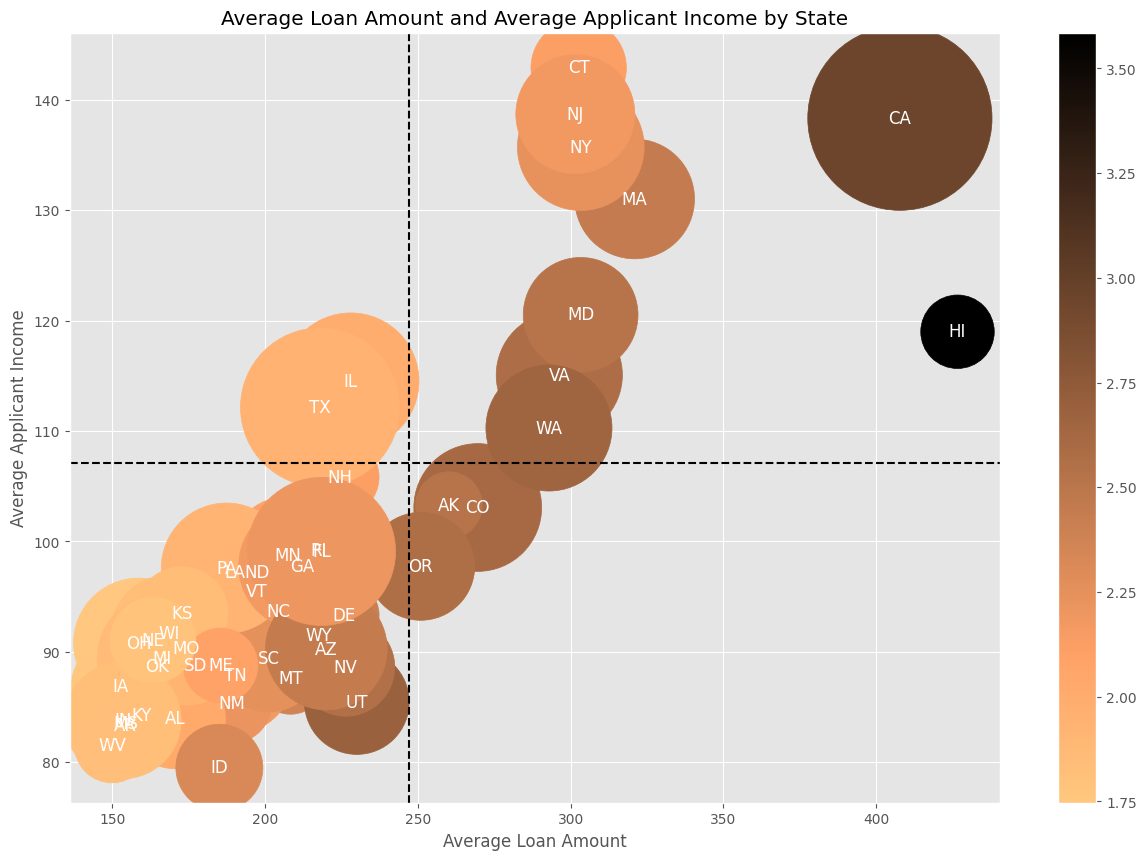

In [44]:
if __name__ == "__main__":
    # The code in this cell calls the function defined above.
    # It plots the average loan amount and average applicant income by state.
    # Before proceeding, it is a good idea to run this code to see the plot.
    plot_avg_loan_income_by_state(avg_loan_income_by_state, final_stats[0], avg_loan_income,state_avg_loan_income_ratio)

### Task 3 (15 pts): Creation of a Basic SQL Table from the Loan-Income-State Data

#### The first step to complete the following tasks is to define two helper functions described below. 

Before moving on to the next subtask, please run the cell below to define the helper functions.

In [ ]:
WAIT_TIME = 10
def connect_to_db(db_name):
    """
    Connect to the database
    IN: db_name, str, the name of the database in MySQL
    OUT: mydb, the database connection
    EXCEPTION: TimeoutError, if the database is not running
    """

    num_of_tries = 0
    while num_of_tries < WAIT_TIME:
        try:
            mydb = connect(host="127.0.0.1", user="root", db=db_name)
            if mydb.is_connected():
                print("Connected")
                break
        except Error as e:
            print(e)

        num_of_tries += 1
        print("Waiting for MySQL to start")
        time.sleep(1)

    if num_of_tries >= WAIT_TIME:
        raise TimeoutError("MySQL is not running")

    return mydb

In [ ]:
def do_query(cursor, query):
    """
    Execute a query and print the results
    IN: cursor, the cursor object
        query, str, the query to be executed
    OUT: list[tuple], the results of the query
    """
    cursor.execute(query)
    res = cursor.fetchall()
    print(cursor.column_names)
    for row in res:
        print(row)
    return res

In [ ]:
if __name__ == "__main__":
    database_name = "HMDA" # change this to your database name
    mydb = connect_to_db(database_name)
    cursor = mydb.cursor()

#### Subtask 3.1 (6 pts): Get the specification of an SQL Table schema encoded by a string

Write a function `get_table_specifications_sql` that takes one input and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **INPUT**: a string `table_name` representing the name of the table.
- **OUTPUT**: a string `table_specifications_sql` encoding the `CREATE TABLE` statements for the SQL database.

Specifically, the schema of the SQL database is as follows:

- `id`: an integer primary key, auto-incremented.
- `state_abbr`: a string of fixed length 2, and it cannot be null.
- `loan_amount`: an integer, and it cannot be null.
- `applicant_income`: an integer, and it cannot be null.

In [ ]:
def get_table_specifications_sql(table_name):
    """
    Get the create table statements for the SQL database
    IN: table_name, str, the name of the table
    OUT: table_specifications_sql, str, the create table statements for the SQL database
    """

    table_specifications_sql = f"""
    __Your_Code_Here__
    """
    return table_specifications_sql

In [ ]:
if __name__ == "__main__":
    table_name = "applicants" # change this to your table name
    table_specifications_sql = get_table_specifications_sql(table_name)
    print(table_specifications_sql)
    do_query(cursor, table_specifications_sql)

#### Subtask 3.2 (9 pts): Insert Loan-Income-State data into the SQL Table

Write a function `insert_data` that takes four inputs and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a connection `mydb` to the SQL database.
- **Input 2**: a cursor `cursor` to the SQL database.
- **Input 3**: a string `table_name` representing the name of the table.
- **Input 4**: a list of tuples `cleaned_data` containing the cleaned data from the CSV file.
- **Output**: an integer representing the number of rows inserted into the table.

Note: make sure to commit the changes to the database.

In [ ]:
def insert_data(mydb, cursor, table_name, cleaned_data):
    """
    Insert the cleaned data into the table
    IN: mydb, the database connection
        cursor, the cursor object to the database
        table_name, str, the name of the table
        cleaned_data, list[tuple], the cleaned data
    OUT: n_rows_inserted, int, the number of rows inserted into the table
    """

    insert_sql = f"""
    __Your_Code_Here__
    """

    # Insert the data in batches of 10,000 rows to avoid memory errors
    n_rows_inserted = 0
    for i in range(0, len(cleaned_data), 10_000):
        """__Your_Code_Here__"""
        
    return n_rows_inserted

In [ ]:
if __name__ == "__main__":
    mydb.rollback()
    n_rows_inserted = insert_data(mydb, cursor, table_name, cleaned_data)
    print(n_rows_inserted)

### Task 4 (35 pts): Detection of High-Loan and High-Risk Applicants and Extension of the Basic SQL Table with this Information

#### Subtask 4.1 (15 pts): Flag high loan applicants

##### Subsubtask 4.1.1 (4 pts): Add a new column `high_loan_flag` to the SQL Table

Write a function `get_add_high_loan_flag_sql` that takes one input and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input**: a string `table_name` representing the name of the table.
- **Output**: a string `add_high_loan_flag_sql` encoding the `ALTER TABLE` statement to add a new column `high_loan_flag` to the SQL database.

Specifically, the `high_loan_flag` is a boolean column that defaults to False and cannot be null.

Hint: You can specify a column as boolean type in MySQL using the `BOOLEAN` keyword.

In [ ]:
def get_add_high_loan_flag_sql(table_name):
    """
    Get the alter table statement to add a new column high_loan_flag to the SQL database
    IN: table_name, str, the name of the table
    OUT: add_high_loan_flag_sql, str, the alter table statement to add a new column high_loan_flag to the SQL database
    """

    return f"""
    __Your_Code_Here__
    """

In [ ]:
if __name__ == "__main__":
    add_high_loan_flag_sql = get_add_high_loan_flag_sql(table_name)
    print(add_high_loan_flag_sql)
    do_query(cursor, add_high_loan_flag_sql)
    mydb.commit()

##### Subsubtask 4.1.2 (7 pts): Update the new column `high_loan` in the SQL Table

Write a function `get update_high_loan_flag_sql` that takes two inputs and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a string `table_name` representing the name of the table.
- **Input 2**: an integer `loan_threshold` representing the threshold for the loan amount to be considered a high loan. The default value is 700.
- **Output**: a string `update_high_loan_flag_sql` encoding the `UPDATE` statement to set the `high_loan_flag` to True for rows with a loan amount greater than the threshold.

Note: A loan amount is considered a high loan if it is strictly greater than the threshold.

Hint: You can use the `UPDATE` statement to set the value of the `high_loan_flag` column to True for rows with a loan amount greater than the threshold.

The syntax for the `UPDATE` statement is as follows:
```sql
UPDATE table_name
SET column_name = updated_value
WHERE condition;
```

In [ ]:
def get_update_high_loan_flag_sql(table_name, loan_threshold=700):
    """
    Get the update statement to set the high_loan_flag to True if the loan amount is greater than the threshold
    IN: table_name, str, the name of the table
        loan_threshold, int, the threshold of the loan amount to be considered as high loan
    OUT: update_high_loan_flag_sql, str, the update statement to set the high_loan_flag to True if the loan amount is greater than the threshold
    """

    return f"""
    __Your_Code_Here__
    """

In [ ]:
if __name__ == "__main__":
    update_high_loan_flag_sql = get_update_high_loan_flag_sql(table_name)
    print(update_high_loan_flag_sql)
    do_query(cursor, update_high_loan_flag_sql)
    mydb.commit()

##### Subsubtask 4.1.3 (4 pts): Find the average applicant income of high loan applicants

Write a function `get_avg_income_high_loan_sql` that takes one input and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input**: a string `table_name` representing the name of the table.
- **Output**: a string `avg_income_high_loan_sql` encoding the SQL query to find the average applicant income of high loan applicants.

Hint: Boolean values can be compared using `boolean_column = 1` for True, and `boolean_column = 0` for False.

In [ ]:
def get_avg_income_high_loan_sql(table_name):
    """
    Get the query to find the average applicant income of high loan applicants
    IN: table_name, str, the name of the table
    OUT: avg_income_high_loan_sql, str, the query to find the average applicant income of high loan applicants
    """

    return f"""
    __Your_Code_Here__
    """

In [ ]:
if __name__ == "__main__":
    avg_income_high_loan_sql = get_avg_income_high_loan_sql(table_name)
    print(avg_income_high_loan_sql)
    do_query(cursor, avg_income_high_loan_sql)

#### Subtask 4.2 (20 pts): Label applicants with a Low/Moderate/High Risk flag

##### Subsubtask 4.2.1 (4 pts): Add a new column `risk_flag` to the SQL Table

Write a function `get_add_risk_flag_sql` that takes one input and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input**: a string `table_name` representing the name of the table.
- **Output**: a string `add_risk_flag_sql` encoding the `ALTER TABLE` statement to add a new column `risk_flag` to the SQL database.

Specifically, the `risk_flag` is a string column of variable length up to two characters, defaults to "H" (High risk), and cannot be null.

In [ ]:
"""
Write a function `get_add_risk_flag_sql` that:

- **Input**: a string `table_name` representing the name of the table.
- **Output**: a string `add_risk_flag_sql` encoding the alter table statement to add a new column `risk_flag` to the SQL database.

Specifically, the `risk_flag` is a string column of variable length up to two characters, and it cannot be null.
"""

def get_add_risk_flag_sql(table_name):
    """
    Get the alter table statement to add a new column risk_flag to the SQL database
    IN: table_name, str, the name of the table
    OUT: add_risk_flag_sql, str, the alter table statement to add a new column risk_flag to the SQL database
    """

    return f"""
    __Your_Code_Here__
    """

In [ ]:
if __name__ == "__main__":
    add_risk_flag_sql = get_add_risk_flag_sql(table_name)
    print(add_risk_flag_sql)
    do_query(cursor, add_risk_flag_sql)
    mydb.commit()

##### Subsubtask 4.2.2 (10 pts): Update the new column `risk_flag` in the SQL Table

Write a function `get_update_risk_flag_sql` that takes two inputs and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a string `table_name` representing the name of the table.
- **Input 2**: a pair of integers `(low_mod_threshold, mod_high_threshold)` representing the thresholds for the ratio of the average loan amount to average applicant income, to be considered as "L", "M", or "H". Defaults to (0.4, 0.8).
- **Output**: a string `update_risk_flag_sql` encoding the SQL query to update the risk flag of the applicants.

Hint: You can use the `CASE` statement in SQL to update the column based on the condition.

```sql
...
CASE
    WHEN condition1 THEN value1
    WHEN condition2 THEN value2
    ...
    ELSE default_value
END

In [ ]:
def get_update_risk_flag_sql(table_name, low_mod_high_thresholds=(0.4, 0.8)):
    """
    Get the update statement to set the risk_flag based on the ratio of the average loan amount and average applicant income
    IN: table_name, str, the name of the table
        low_mod_high_thresholds, tuple(float, float), the thresholds of the ratio of the average loan amount and average applicant income to be considered as "L"/"M"/"H"
    OUT: update_risk_flag_sql, str, the update statement to set the risk_flag based on the ratio of the average loan amount and average applicant income
    """

    low, mod = low_mod_high_thresholds
    return f"""
    __Your_Code_Here__
    """


In [ ]:
if __name__ == "__main__":
    update_risk_flag_sql = get_update_risk_flag_sql(table_name)
    print(update_risk_flag_sql)
    do_query(cursor, update_risk_flag_sql)
    mydb.commit()

##### Subsubtask 4.2.3 (6 pts): Find the percentage of high-risk applicants per state

Write a function `get_high_risk_percentage_sql` that takes one input and produces one output as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input**: a string `table_name` representing the name of the table.
- **Output**: a string `high_risk_percentage_sql` encoding the SQL query to find the percentage of high-risk applicants per state.

Note: the percentage of high-risk applicants is the number of high-risk applicants divided by the total number of applicants per state.

The SQL query should return a table with the following columns:

- `state_abbr`: the state abbreviation.
- `high_risk_percentage`: as two decimal floating-point numbers. For example, 0.25 represents 25%.

Hint: You may need to nest the `SELECT` statement in the `FROM` clause to calculate the total number of applicants per state.

```sql
SELECT temp_table.state_abbr, ...
FROM (
    SELECT ...
    FROM table_name
) AS temp_table
```

In [ ]:
"""
Write a function `get_high_risk_percentage_sql` that:

- **Input**: a string `table_name` representing the name of the table.
- **Output**: a string `high_risk_percentage_sql` encoding the SQL query to find the percentage of high-risk applicants per state.

Note: the percentage of high-risk applicants is the number of high-risk applicants divided by the total number of applicants per state.

The SQL query should return a table with the following columns:

- `state_abbr`: the state abbreviation.
- `high_risk_percentage`: as integer representing the percentage of high-risk applicants.
"""

def get_high_risk_percentage_sql(table_name):
    """
    Get the query to find the percentage of high-risk applicants per state
    IN: table_name, str, the name of the table
    OUT: high_risk_percentage_sql, str, the query to find the percentage of high-risk applicants per state
    """

    return f"""
    __Your_Code_Here__
    """

In [ ]:
if __name__ == "__main__":
    high_risk_percentage_sql = get_high_risk_percentage_sql(table_name)
    print(high_risk_percentage_sql)
    high_risk_percentage = do_query(cursor, high_risk_percentage_sql)

### Task 5 (5 pts): Creation of a Scatter Plot of High-Risk States (average income versus average loan amount)

Write a function `plot_high_risk_percentage` that takes four inputs and produces a plot as indicated below. You just need to complete the missing code in the cell containing the string `"""__Your_Code_Here__"""`.

- **Input 1**: a dictionary `avg_loan_income_by_state` representing the average loan amount and average applicant income by state.
- **Input 2**: a dictionary `state_abbr_stat` representing the number of applicants by state.
- **Input 3**: a tuple `(avg_loan_amount, avg_applicant_income)` representing the average loan amount and average applicant income for all applicants.
- **Input 4**: a list of tuples `high_risk_percentage` representing the percentage of high-risk applicants per state.
- **Plot**: a scatter plot of the average loan amount and average applicant income by state.
    - **x-axis**: average loan amount.
    - **y-axis**: average applicant income.
    - **size**: the number of applicants, where the radius of each circle is proportional to the square root of the number of applicants. You may use some scaling factor to make the circles well sized.
    - **color**: the percentage of high-risk applicants per state, with the colormap set to `copper_r`.
    - **vertical line**: the average loan amount for all applicants (in a dashed black line).
    - **horizontal line**: the average applicant income for all applicants (in a dashed black line).

In [ ]:
def plot_high_risk_percentage(avg_loan_income_by_state, state_abbr_stat, avg_loan_income, high_risk_percentage):
    """
    Plot the percentage of high-risk applicants per state
    IN: avg_loan_income_by_state, dict{str: tuple(float, float)}, the average loan amount and average applicant income by state
        state_abbr_stat, dict{str: int}, the number of applicants by state
        avg_loan_income, tuple(float, float), the average loan amount and average applicant income for all applicants
        high_risk_percentage, list[tuple(str, float)], the percentage of high-risk applicants per state
    """

    # convert the high_risk_percentage to a dictionary
    high_risk_dict = dict(high_risk_percentage)

    # extract the states, average loan amounts, average applicant incomes, sizes, and colors
    states = []
    avg_loans = []
    avg_incomes = []
    sizes = []
    colors = []
    for state, (loan, income) in avg_loan_income_by_state.items()
        states.append(state)
        avg_loans.append(loan)
        avg_incomes.append(income)
        sizes.append(np.sqrt(state_abbr_stat[state]) * 10)  
        colors.append(high_risk_dict.get(state, 0)) 

    # increase the size of the plot to avoid crowding
    plt.figure(figsize=(15, 10))
    # use ggplot style. it's gray background, easy for colors to stand out
    plt.style.use('ggplot')

    
    # plot the average loan amount and average applicant income by state
    scatter = plt.scatter(avg_loans, avg_incomes, s=sizes, c=colors, cmap='copper_r', alpha=0.8, edgecolors="k")

    # add horizontal and vertical lines for the average loan amount and average applicant income of all applicants
    plt.axvline(x=avg_loan_income[0], color='black', linestyle='--')
    plt.axhline(y=avg_loan_income[1], color='black', linestyle='--')

    # add state names to the plot
    for i, state_abbr in enumerate(states):
        plt.text(avg_loans[i], avg_incomes[i], state_abbr, fontsize=12, c='white', ha='center', va='center')

    # add labels, title, and colorbar to the plot
    plt.xlabel('Average Loan Amount')
    plt.ylabel('Average Applicant Income')
    plt.title('Average Loan Amount and Average Applicant Income by State')
    plt.colorbar()
    plt.show()

### Note: Do not forget to close the connection to the database.

In [ ]:
if __name__ == "__main__":
    cursor.close()
    mydb.close()